<a href="https://colab.research.google.com/github/LeszekWawi/BoneMarrowCellClassifier/blob/main/BoneMarrowClassifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing relevant libraries for date import,processing and model building

In [255]:
import tensorflow as tf
import zipfile
!apt install unzip
import albumentations

import os
from PIL import Image
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,DepthwiseConv2D,Activation,Add
import random
import math
from google.colab.patches import cv2_imshow
!pip install lime
from lime import lime_image
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import mark_boundaries
!pip install zipfile
import zipfile
from tensorflow.keras.models import load_model
import json
import pickle
import PIL
import requests
import json

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [256]:
### mounting the GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [257]:
### values constant throughtout the code
Img_res=(224, 224)
Batch_size=64
Epochs=100
num_classes = 8
numAUG_classes=8
dictio={0:'ART',1:'BLA',2:'EBO',3:'LYT',4:'NGB',5:'NGS',6:'PLM',7:'PMO'}#dictionary used for label mapping
model_name={0:'BaseModel',1:'Model_Dropout',2:'Model_IRB',3:'Model_IRB-Augmented',4:'augmentedModel_IRB'}

In [258]:
### extracting zipped image files
with zipfile.ZipFile('/content/drive/MyDrive/BoneData/Dataset (2).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/nowy')

In [259]:
### getting the images as DataFrame

def get_df_data(image_path):
    images_file = []
    for (dirname, subdirs, filenames) in os.walk(image_path):
        full_filenames = [os.path.join(dirname, f) for f in filenames]
        file_name = [f for f in filenames]
        label = [f[:3] for f in filenames]
        images_file.append(full_filenames)

        dane = pd.DataFrame(full_filenames, columns=['image_path'])

        dane['label'] = label
        dane['label'] = dane['label'].astype('str')
        dane['file_name'] = file_name
        return dane#DataFrame combining image/label with pathway to particular image


dane=get_df_data('/content/sample_data/nowy/Dataset')

In [260]:
dane.head()

,image_path,label,file_name
0,/content/sample_data/nowy/Dataset/PLM_04910.jpg,PLM,PLM_04910.jpg
1,/content/sample_data/nowy/Dataset/EBO_12488.jpg,EBO,EBO_12488.jpg
2,/content/sample_data/nowy/Dataset/LYT_09293.jpg,LYT,LYT_09293.jpg
3,/content/sample_data/nowy/Dataset/ART_15904.jpg,ART,ART_15904.jpg
4,/content/sample_data/nowy/Dataset/LYT_23684.jpg,LYT,LYT_23684.jpg


visualization of the size of each class

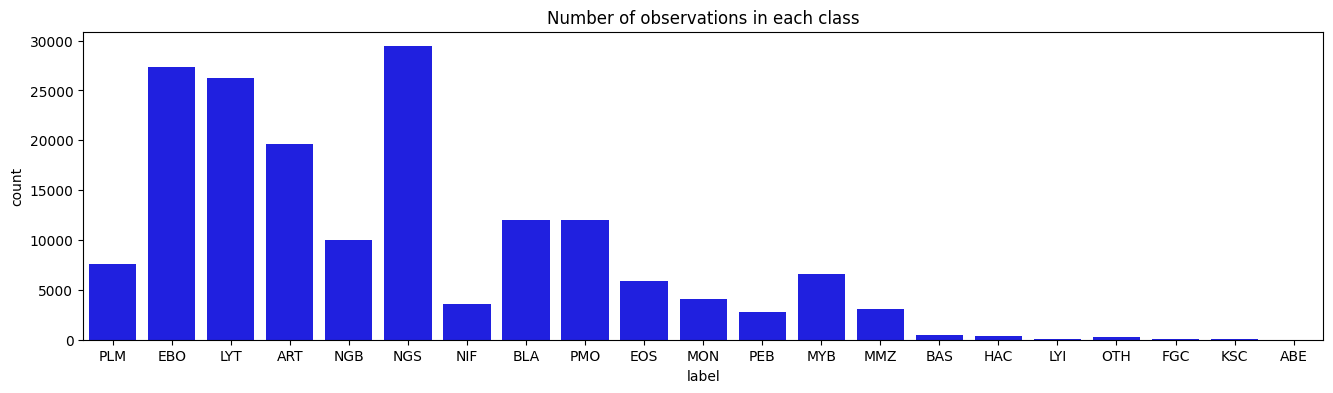

In [261]:
plt.figure(figsize=(16, 4))
plt.title("Number of observations in each class")
sns.countplot(x=dane['label'],color='b')
plt.savefig('/content/drive/MyDrive/class_count.png')

There are several extremelly low-count categories which makes it difficult to efficiently classify so in order to build high-performance classifier I have to reduct extremelly low-count classes

In [262]:
unique_labels = dane['label'].unique()
temp_df = pd.DataFrame()
data_df=pd.DataFrame()

for label in unique_labels:
    label_df = dane[dane['label'] == label]
    if len(label_df) >= 0.04 * len(dane):      ### the treshold set for 4% of total data length
        data_df=pd.concat([data_df,label_df])
    else:
        pass

visualization of the size of each class after class cut-off

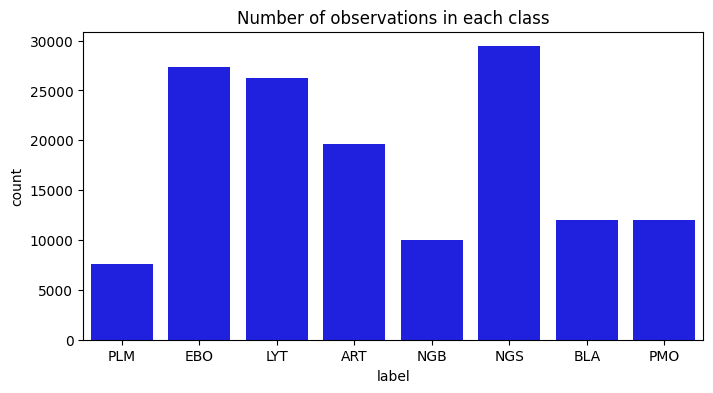

In [263]:
plt.figure(figsize=(8, 4))
plt.title("Number of observations in each class")
sns.countplot(x=data_df['label'],color='b')
plt.savefig('/content/drive/MyDrive/red_class_count.png')

visualization of examplary images from each class


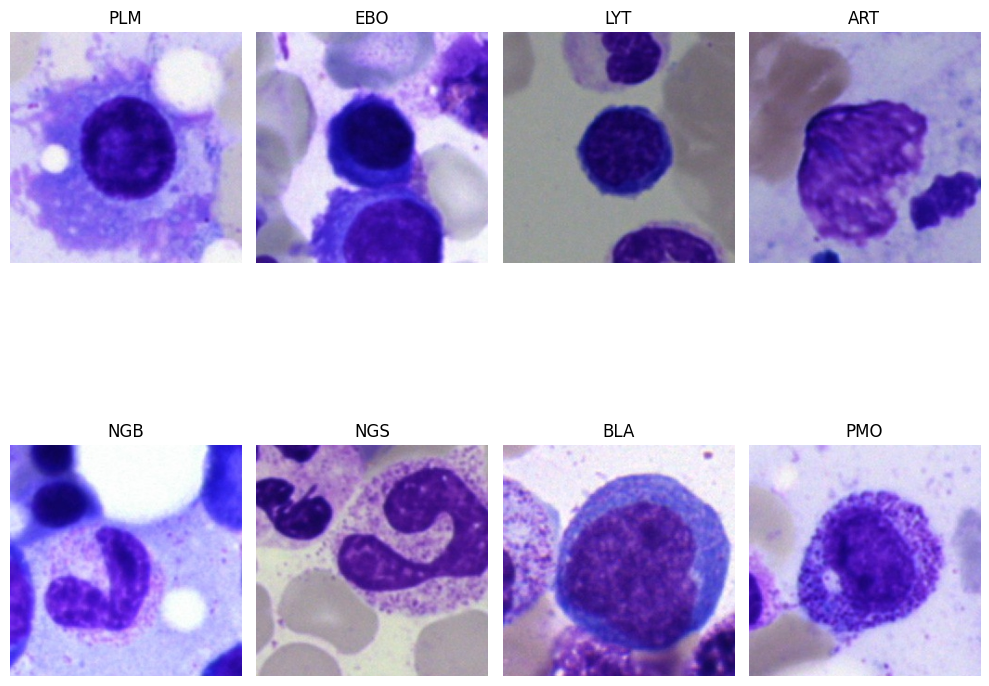

In [264]:
def vis(df):
    num_cols=4
    num_rows=2
    num_samples_per_class = 1
    label_unique = data_df['label'].unique()[:num_classes]
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for i, label in enumerate(label_unique):
        label_data = dane[dane['label'] == label]
        sampled_data = label_data.sample(num_samples_per_class, replace=False)

        row_idx = i // num_cols
        col_idx = i % num_cols

        for j, (_, row) in enumerate(sampled_data.iterrows()):
            image = cv2.imread(row['image_path'])
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


            ax[row_idx, col_idx].imshow(image_rgb)
            ax[row_idx, col_idx].set_title(label)
            ax[row_idx, col_idx].axis('off')

    plt.tight_layout()
plt.show()
vis(data_df)
plt.savefig('/content/drive/MyDrive/example_images.png')

Pre-processing of data (images) for the Neuronal Networks (tensorflow)

In [265]:
### one hot encoding of 8 categorical label classes

#Encode the label using LabelEncoder
le = LabelEncoder()
data_df['label_enc']=le.fit_transform(data_df['label'])

# Convert the encoded target variable to one-hot encoded format
target_encoded = le.fit_transform(data_df['label'])
one_hot_targets = tf.keras.utils.to_categorical(target_encoded, num_classes=num_classes)

# Create a new column in the DataFrame with the one-hot encoded labels
data_df['target'] = one_hot_targets.astype(np.int32).tolist()
data_df.head()

,image_path,label,file_name,label_enc,target
0,/content/sample_data/nowy/Dataset/PLM_04910.jpg,PLM,PLM_04910.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
13,/content/sample_data/nowy/Dataset/PLM_01862.jpg,PLM,PLM_01862.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
48,/content/sample_data/nowy/Dataset/PLM_07496.jpg,PLM,PLM_07496.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
50,/content/sample_data/nowy/Dataset/PLM_04126.jpg,PLM,PLM_04126.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
115,/content/sample_data/nowy/Dataset/PLM_03607.jpg,PLM,PLM_03607.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"


Generation of images for Data Augmentation. Three classes with the lowest f1-score were chosen for augmentation

Data Augmentation with albumentations library. The images from three the least abundant classes were subjected to several types of transformation,saved. Paths to the images were coupled with data within a DataFrame.

In [266]:
df_AUG=data_df[data_df['label_enc'].isin([4,6,1])]
df_AUG.head()

,image_path,label,file_name,label_enc,target
0,/content/sample_data/nowy/Dataset/PLM_04910.jpg,PLM,PLM_04910.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
13,/content/sample_data/nowy/Dataset/PLM_01862.jpg,PLM,PLM_01862.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
48,/content/sample_data/nowy/Dataset/PLM_07496.jpg,PLM,PLM_07496.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
50,/content/sample_data/nowy/Dataset/PLM_04126.jpg,PLM,PLM_04126.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"
115,/content/sample_data/nowy/Dataset/PLM_03607.jpg,PLM,PLM_03607.jpg,6,"[0, 0, 0, 0, 0, 0, 1, 0]"


In [267]:
def AUG_df (df,dir_path):
    augmented_data=[]
    for _, row in df.iterrows():
            label = row['label']
            image = cv2.imread(row['image_path'])
            image_resized = cv2.resize(image, Img_res)
            image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB) / 255.

            ### definition of augmentation
            transform_oneof = albumentations.Compose([albumentations.Resize(256, 256),albumentations.RandomCrop(224, 224),
            albumentations.OneOf([albumentations.HorizontalFlip(p=1),albumentations.RandomRotate90(p=1),albumentations.VerticalFlip(p=1)]),
            albumentations.OneOf([albumentations.MotionBlur(p=1),albumentations.OpticalDistortion(p=1),albumentations.GaussNoise(p=1)])])

            ### data augmentation
            augmented=transform_oneof(image=image_rgb)
            augmented_image = augmented['image'].astype(np.uint8)

            ### saving newly generated images along with paths as pd.DataFrame
            i = 0
            while i <= len(df):
                file_name = 'n_'+str(i) + "_" + label
                file_path = os.path.join(dir_path, file_name+'.jpg')
                cv2.imwrite(file_path, augmented_image)

                augmented_data.append({'image_path': file_path, 'label': label})
                i += 1

            augmented_df = pd.DataFrame(augmented_data)
    return augmented_df

In [268]:
# AUG_df=AUG_df(df_AUG,'/content/drive/MyDrive/AUG_dataset/AUG_dataset')

Generating datasets for classification

In [269]:
#definition of the generator for dataset
def get_generator(df):
    def generator():
        for _, row in df.iterrows():
            label = row['target']
            image = cv2.imread(row['image_path'])
            image_resized = cv2.resize(image, Img_res)
            image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB) / 255.
            yield image_rgb,label
    return generator

In [270]:
### function for dataset generation

def get_data():
    train_df, test_df = train_test_split(data_df, test_size=0.1,random_state=42,stratify=data_df['target'])
    train_df, val_df = train_test_split(train_df, test_size=0.1,random_state=42,stratify=train_df['target']) #data splitting into training,validation and test datasets

    output_signature = (tf.TensorSpec((*Img_res, 3), dtype=tf.float32), tf.TensorSpec((8,), dtype=tf.int32)) #definition of output signature for the datasets

    ### training dataset
    train_ds = tf.data.Dataset.from_generator(
        get_generator(train_df),
        output_signature=output_signature)

    train_ds = train_ds.shuffle(100)
    train_ds = train_ds.batch(Batch_size)
    train_ds=train_ds.repeat() #prevents data limitation during training.Training set will be used is a loop.

    ### validation dataset
    val_ds = tf.data.Dataset.from_generator(
        get_generator(val_df),
        output_signature=output_signature)
    val_ds = val_ds.batch(Batch_size)

    ### test dataset
    test_ds = tf.data.Dataset.from_generator(
        get_generator(test_df),
        output_signature=output_signature)
    test_ds = test_ds.batch(Batch_size)



    return train_ds,val_ds,test_ds,test_df

In [271]:
train_ds,val_ds,test_ds,test_df=get_data()

Data augmentation and generation of augmented training set

In [272]:
### function for augmented training dataset generation
def AUG_get_data():
    train_df, test_df = train_test_split(data_df, test_size=0.1,random_state=42,stratify=data_df['target'])
    train_df, val_df = train_test_split(train_df, test_size=0.1,random_state=42,stratify=train_df['target'])

    train_df=pd.concat([train_df,AUG_df])### actual supplementing training dataset with newly generated uagmented data

    output_signature = (tf.TensorSpec((*Img_res, 3), dtype=tf.float32), tf.TensorSpec((8,), dtype=tf.int32))

    ### training dataset
    train_ds = tf.data.Dataset.from_generator(
        get_generator(train_df),
        output_signature=output_signature)

    train_ds = train_ds.shuffle(100)
    train_ds = train_ds.batch(Batch_size)
    train_ds=train_ds.repeat()

    ### validation dataset
    val_ds = tf.data.Dataset.from_generator(
        get_generator(val_df),
        output_signature=output_signature)
    val_ds = val_ds.batch(Batch_size)

    ### test dataset
    test_ds = tf.data.Dataset.from_generator(
        get_generator(test_df),
        output_signature=output_signature)
    test_ds = test_ds.batch(Batch_size)



    return train_ds,val_ds,test_ds,test_df

In [273]:
# trainAUG_ds,valAUG_ds,testAUG_ds,testAUG_df=AUG_get_data()

Definition of CNN models used

In [274]:
### base model of CNN

model= tf.keras.models.Sequential([ tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape = (*Img_res,3)),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    # tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(8, activation ='softmax')])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 222, 222, 128)     3584      
                                                                 
 conv2d_105 (Conv2D)         (None, 220, 220, 128)     147584    
                                                                 
 conv2d_106 (Conv2D)         (None, 218, 218, 128)     147584    
                                                                 
 conv2d_107 (Conv2D)         (None, 216, 216, 128)     147584    
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 108, 108, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_108 (Conv2D)         (None, 106, 106, 256)     295168    
                                                      

In [275]:
# ### Dropuot layer implemented into base model after convolutional and fully connected blocks

model_Drop=tf.keras.models.Sequential([ tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape = (*Img_res,3)),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.3),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(8, activation ='softmax')])
model_Drop.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 222, 222, 128)     3584      
                                                                 
 conv2d_119 (Conv2D)         (None, 220, 220, 128)     147584    
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 110, 110, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_120 (Conv2D)         (None, 108, 108, 256)     295168    
                                                                 
 conv2d_121 (Conv2D)         (None, 106, 106, 256)     590080    
                                                                 
 conv2d_122 (Conv2D)         (None, 104, 104, 256)     590080    
                                                      

 implementing inverted_residual_blocks into the CNN architecture

In [276]:
input_layer = tf.keras.layers.Input(shape=(*Img_res, 3))

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(input_layer)

init_model = x
x = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, init_model])

init_model_ = x
x = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, init_model_])

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x= tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x= tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x=  tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dropout(rate=0.3)(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dense(64, activation='relu')(x)
x=tf.keras.layers.Dense(8, activation='softmax')(x)

IRB_model=tf.keras.Model(inputs=input_layer, outputs=x)


IRB_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_130 (Conv2D)         (None, 222, 222, 128)        3584      ['input_5[0][0]']             
                                                                                                  
 depthwise_conv2d_8 (Depthw  (None, 222, 222, 128)        1280      ['conv2d_130[0][0]']          
 iseConv2D)                                                                                       
                                                                                                  
 batch_normalization_16 (Ba  (None, 222, 222, 128)        512       ['depthwise_conv2d_8[0][

Definition of new model trained on augmented training dataset

In [277]:
# IRBmodel_AUG architecture is the same as IRB_model but the model is trained on Augmented training data
input_layer = tf.keras.layers.Input(shape=(*Img_res, 3))

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(input_layer)

init_model = x
x = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, init_model])

init_model_ = x
x = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, init_model_])

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x= tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x= tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x=  tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dropout(rate=0.3)(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dense(64, activation='relu')(x)
x=tf.keras.layers.Dense(8, activation='softmax')(x)

IRBmodel_AUG=tf.keras.Model(inputs=input_layer, outputs=x)
IRBmodel_AUG.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_143 (Conv2D)         (None, 222, 222, 128)        3584      ['input_6[0][0]']             
                                                                                                  
 depthwise_conv2d_10 (Depth  (None, 222, 222, 128)        1280      ['conv2d_143[0][0]']          
 wiseConv2D)                                                                                      
                                                                                                  
 batch_normalization_20 (Ba  (None, 222, 222, 128)        512       ['depthwise_conv2d_10[0]

In [278]:
### custom callbacks- saving training chackpoint (useful in working at colab and risk of occasional venv corruption)
#for base_model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/model_checkpoint.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)
#and for model_Dropout
checkpoint_callback_Drop = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/model_Drop_checkpoint.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)
# and for IRB_model
checkpoint_callback_IRB = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/IRB_model_checkpoint.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)
# early stopping
Early_Stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [279]:
# checkpoint callback for IRBmodel_AUG
checkpoint_callback_IRB_AUG = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/IRB_modelAUGcheckpoint.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1)

models compilation

In [280]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks =[ Early_Stopping,checkpoint_callback]

In [281]:
model_Drop.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks =[ Early_Stopping,checkpoint_callback_Drop]

In [282]:
IRB_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks =[ Early_Stopping,checkpoint_callback_IRB]

In [283]:
IRBmodel_AUG.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks =[ Early_Stopping,checkpoint_callback_IRB_AUG]

training of the models

In [284]:
# history = model.fit(train_ds, validation_data=val_ds, batch_size=Batch_size,epochs=Epochs, steps_per_epoch=200,callbacks=callbacks)

In [285]:
# history_Drop = model_Drop.fit(train_ds, validation_data=val_ds, batch_size=Batch_size,epochs=Epochs, steps_per_epoch=200,callbacks=callbacks)

In [286]:
# history_IRB = IRB_model.fit(train_ds, validation_data=val_ds, batch_size=Batch_size,epochs=Epochs, steps_per_epoch=200,callbacks=callbacks)

In [287]:
# history_AUG=IRBmodelAUG.fit(trainAUG_ds,validation_data=val_ds, batch_size=Batch_size,epochs=Epochs, steps_per_epoch=200,callbacks=callbacks)

In [288]:
### examination of the course of training: plotting accuracy and loss throughout training

def plot_epochs_acc_loss(history_list):
    acc = history_list.history['accuracy']
    val_acc = history_list.history['val_accuracy']
    loss = history_list.history['loss']
    val_loss = history_list.history['val_loss']
    epochs = np.arange(1, len(acc)+1)

    fig = plt.figure(figsize=(16, 6))
    # Accuracy
    fig.add_subplot(211)
    plt.plot(epochs, acc, color='green', label='Train')
    plt.plot(epochs, val_acc, color='red', label='Validation')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.xlim(epochs.min(), epochs.max())

    # Loss
    fig.add_subplot(212)
    plt.plot(epochs, loss, color='green', label='Train')
    plt.plot(epochs, val_loss, color='red', label='Validation')
    plt.legend(loc='lower right')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.xlim(epochs.min(), epochs.max())

    plt.show()

In [289]:
# plot_epochs_acc_loss(history)

In [290]:
# ### restoring weights from the "best" checkpoint for each model

model.load_weights('/content/drive/MyDrive/checkpoints/model_checkpoint.h5')
model_Drop.load_weights('/content/drive/MyDrive/checkpoints/model_Drop_checkpoint.h5')
IRB_model.load_weights('/content/drive/MyDrive/checkpoints/model_IRBcheckpoint.h5')
IRBmodel_AUG.load_weights('/content/drive/MyDrive/checkpoints/IRB_modelAUG_checkpoint.h5')


In [291]:
model_path = '/content/drive/MyDrive/checkpoints/model_checkpoint.h5'
model_Drop_path='/content/drive/MyDrive/checkpoints/model_Drop.h5'
IRB_model_path='/content/drive/MyDrive/checkpoints/model_IRB_red.h5'
IRBmodel_AUG_path='/content/drive/MyDrive/checkpoints/IRB_modelAUG.h5'

In [292]:
### saving models

# model.save(model_path)
# IRB_model.save(IRB_model_path)
# model_Drop.save(model_Drop_path)
# IRBmodel_AUG.save(IRBmodel_AUG_path)

### Loading saved model

# model = load_model(model_path)
# model_Drop=load_model(model_Drop_path)
# IRB_model=load_model(IRB_model_path)

evaluation of the models with test dataset

In [293]:
# loss,accuracy=model.evaluate(test_ds)
# loss_Drop,accuracy_Drop=model_Drop.evaluate(test_ds)
# loss_IRB,accuracy_IRB=IRB_model.evaluate(test_ds)
# loss_IRB_AUG,accuracy_IRB_AUG=IRBmodel_AUG.evaluate(test_ds)

Predictions of test data made with various models

In [294]:
pred=model.predict(
    test_ds)

pred_Drop=model_Drop.predict(
    test_ds)

pred_IRB=IRB_model.predict(
    test_ds)

226/226 [==============================] - 193s 856ms/step


In [295]:
pred_IRBmodel_AUG=IRBmodel_AUG.predict(test_ds)

226/226 [==============================] - 193s 858ms/step


Parameters used by visualization functions:

1.  List of models and compatible list of prediction results made for each model
2.  Dictionaries necessary for naming labels and models,
3.  Numer of classes in classification



In [296]:
model_list=[model,model_Drop,IRB_model,IRBmodel_AUG]
pred_list=[pred,pred_Drop,pred_IRB,pred_IRBmodel_AUG]
dictio={0:'ART',1:'BLA',2:'EBO',3:'LYT',4:'NGB',5:'NGS',6:'PLM',7:'PMO'}#dictionary used for label mapping
model_name={0:'BaseModel',1:'Model_Dropout',2:'Model_IRB',3:'Model_IRB-Augmented',4:'augmentedModel_IRB'}#dictionary used for model names mapping
num_classes=8

Visualization of the confussion matrices for each model

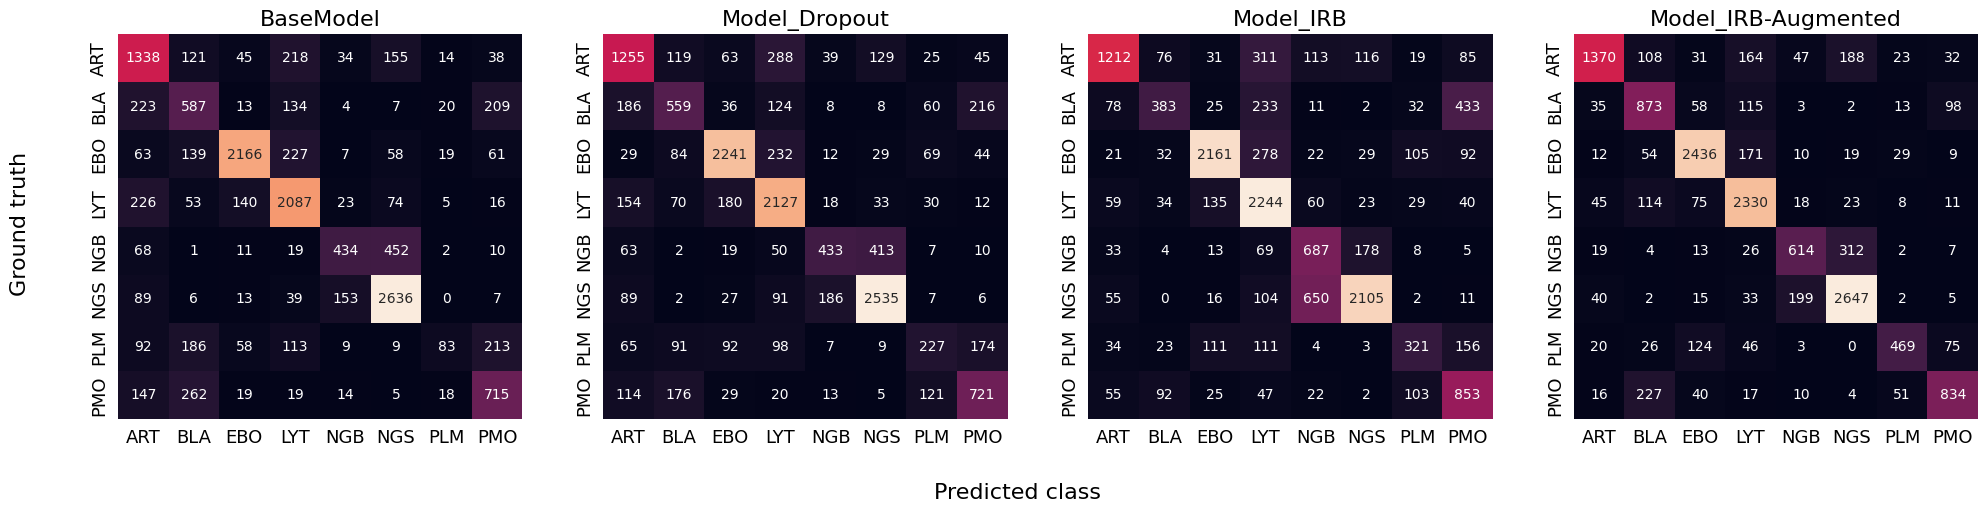

4

In [347]:
def cm_data(dataset, models: list, pred_list: list, num_classes: int, dictio: dict):
    test_labels = []
    tests = []
    model_preds = [[] for _ in range(len(models))]  # Create a list of empty lists for model predictions
    cm = []

    for features, labels in test_ds:
        test_labels.append(np.array(labels))

    for i in range(len(test_labels)):
        for j in range(len(test_labels[i])):
            tests.append(np.argmax(test_labels[i][j]))

    for m in range(len(models)):
        for k in range(len(pred_list[m])):
            model_preds[m].append(np.argmax(pred_list[m][k]))  # Store predictions for the current model

    fig, ax = plt.subplots(1, len(models), figsize=(24, 5),sharex=True)

    for i in range(len(models)):
        mod=[]
        cm.append(tf.math.confusion_matrix(tests, model_preds[i], num_classes=num_classes))
        mod.append(i)
        sns.heatmap(cm[i], annot=True, cbar=False, fmt='d', xticklabels=list(dictio.values()), yticklabels=list(dictio.values()), ax=ax[i])
        ax[i].set_title(model_name[i],size=16)
        ax[i].tick_params(axis='x', bottom=False, labelbottom=True,labelsize=13)
        ax[i].tick_params(axis='y', left=False, labelleft=True,labelsize=13)
    fig.text(0.5, -0.05, 'Predicted class', ha='center',size=16)
    fig.text(0.08, 0.5, 'Ground truth', va='center', rotation='vertical',size=16)
    plt.show()
    return len(model_preds)


cm_data(test_ds,model_list,pred_list,num_classes,dictio)

comparison of F1-scores obtained for each class by models

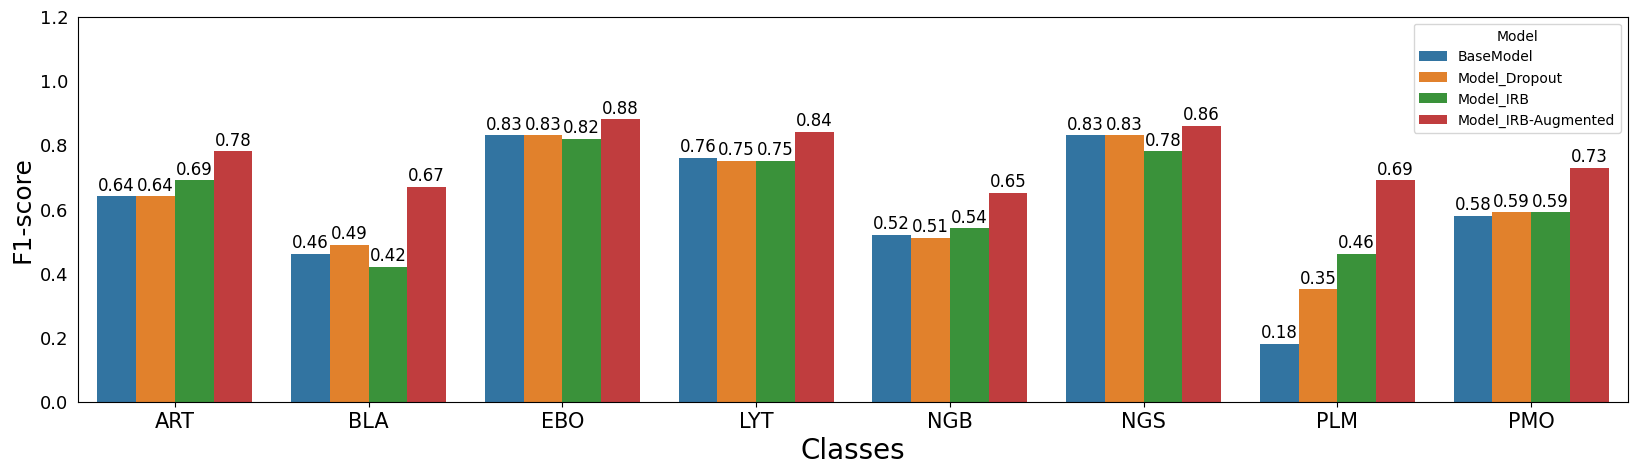

In [353]:
def visualize_class_report(dataset, models, pred_list):
    test_labels = []
    test_labels_ = []
    tests = []
    model_preds = [[] for _ in range(len(models))]
    preds_ = []
    class_reports = [[] for _ in range(len(models))]
    lines = [[] for _ in range(len(models))]
    data = [[] for _ in range(len(models))]
    df = [[] for _ in range(len(models))]
    to_graph = [[] for _ in range(len(models))]
    table = pd.DataFrame()  # Initialize an empty DataFrame

    for features, labels in dataset:  # Assuming "test_ds" is your dataset
        test_labels.append(np.array(labels))

    for i in range(len(test_labels)):
        test_labels_.append(test_labels[i])
        for j in range(len(test_labels[i])):
            tests.append(np.argmax(test_labels[i][j]))

    for m in range(len(models)):
        for k in range(len(pred_list[m])):
            model_preds[m].append(np.argmax(pred_list[m][k]))
            preds_.append(model_preds)  # Store predictions for the current model

    for i in range(len(models)):
        class_reports[i] = classification_report(tests, model_preds[i])

        lines[i] = class_reports[i].split('\n')
        data[i] = [line.split()[1:] for line in lines[i][2:-3]]
        df[i] = pd.DataFrame(data[i], columns=['precision', 'recall', 'f1-score', 'support']).apply(pd.to_numeric)

        # Add the 'f1-score' column from df[i] to the 'table' DataFrame
        table[i] = df[i]['f1-score']
    table=table[:len(dictio)]
    table= table.reset_index().set_index(keys='index')
    table.index=table.index.map(dictio)

    table.columns=table.columns.map(model_name)
    table=table.stack().to_frame().reset_index()
    table.rename(columns={'level_1':'Model'},inplace=True)

    fig,ax=plt.subplots(figsize=(20,5))

    plots = sns.barplot(data=table,x='index', y=0, hue='Model')
    plt.ylim(0,1.2)
    plt.tick_params(axis='y', left=False, labelleft=True,labelsize=13)
    plt.tick_params(axis='x',labelsize=15)

    for bar in plots.patches:#inserting annotations with actual value into each bar
        plots.annotate(format(bar.get_height(), '.2f'),
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=12, xytext=(0, 8),
                           textcoords='offset points')
    plt.xlabel('Classes',size=20)
    plt.ylabel('F1-score',size=18)

    plt.show()
    return

visualize_class_report(test_ds,model_list,pred_list)


interpretability of predictions using lime library

In [300]:
### function for getting Actual and Predicted class for each image defined by the index from dataset

def get_image(idx:int,model:str):  ### idx stands for the row index for tested image within the dataset
    imag=data_df['image_path'].iloc[idx]
    Actual_class=data_df['label'].iloc[idx]
    image= cv2.imread(imag)
    image = cv2.resize(image, Img_res)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.
    image_pred=tf.expand_dims(image, axis=0)
    Predicted_class=dictio[np.argmax(model.predict(image_pred))]
    return [image,Predicted_class,Actual_class]


### function for visual explanation of classifier results

def get_interpret(idx,model:str):
    explainer = lime_image.LimeImageExplainer()
    image_,Predicted_class,Actual_class=get_image(idx,model)
    explanation = explainer.explain_instance(image_, model.predict, top_labels=5, hide_color=0, num_samples=200)

    # temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    print('Predicted class---',Predicted_class)
    print('Actual class---', Actual_class)
    if Actual_class==Predicted_class:
        print('Correctly Classified')
    else:
        print('---Missclassified---')

1/1 [==============================] - 1s 848ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
Predicted class--- PLM
Actual class--- PLM
Correctly Classified


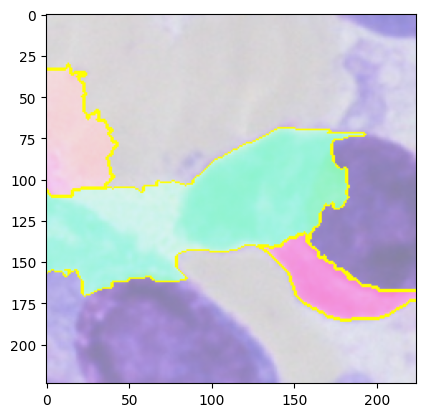

In [301]:
get_interpret(131,IRBmodel_AUG)
# plt.savefig('/content/drive/MyDrive/model_Drop.png')

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 1s 814ms/step
Predicted class--- BLA
Actual class--- BLA
Correctly Classified


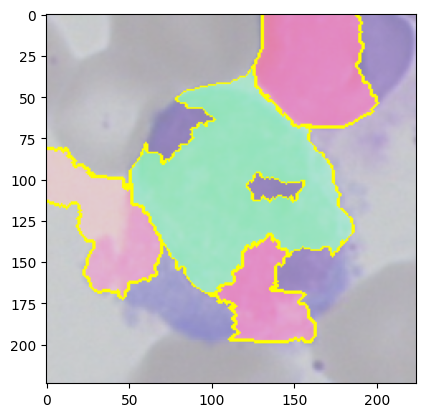

In [302]:
get_interpret(131350,IRBmodel_AUG)